# What is Parallel Computing?

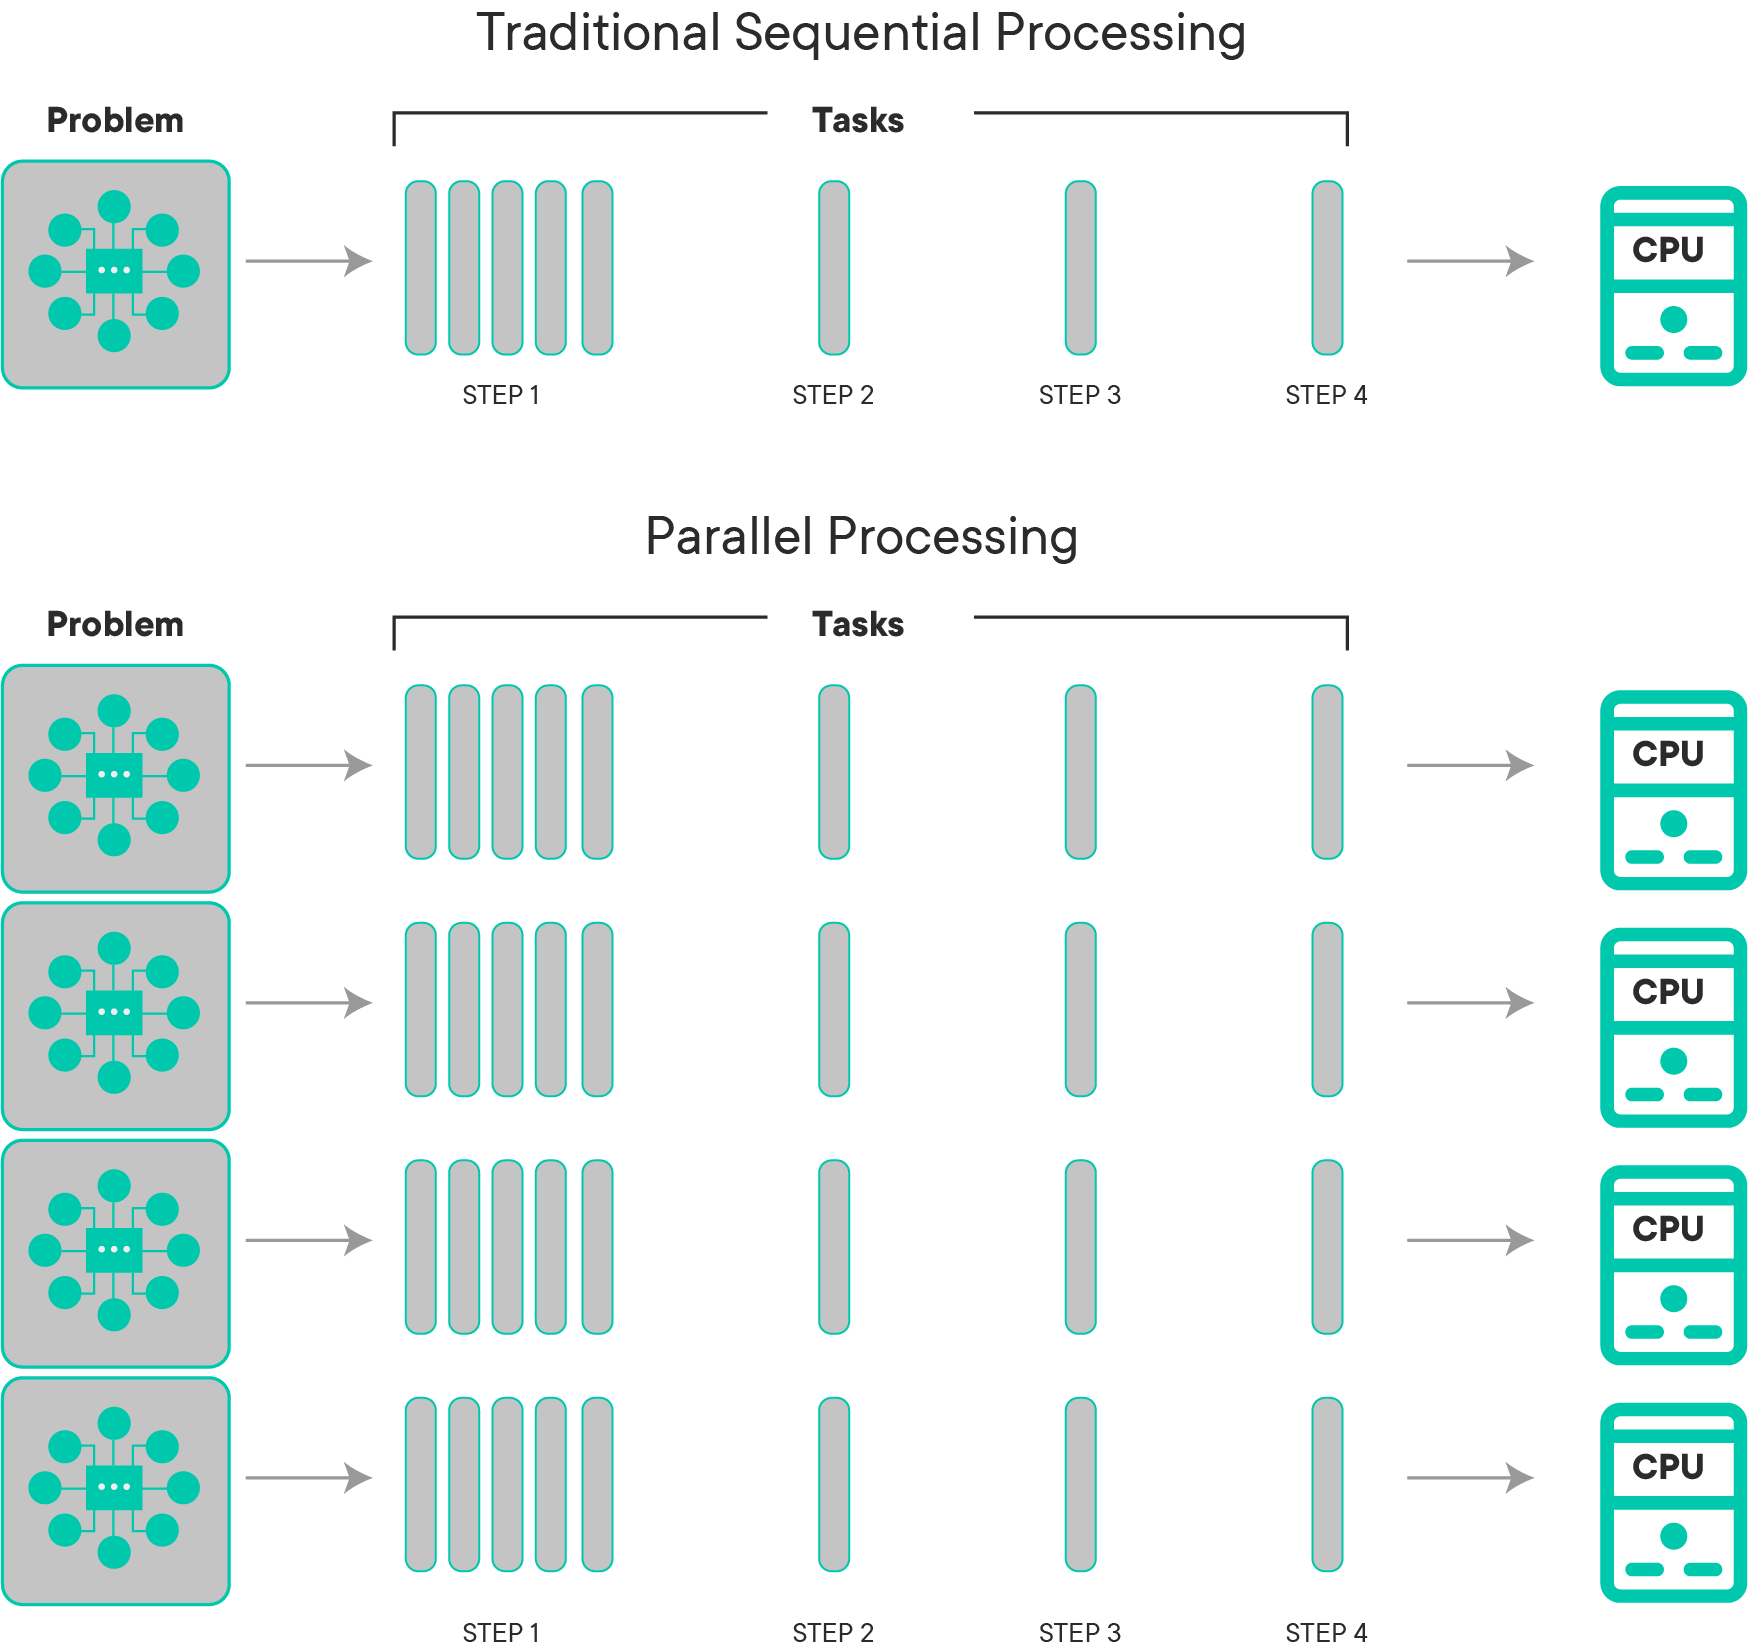

# Resilient Distributed Datasets

Resilient Distributed Datasets (RDD) are fundamental data structures of Spark. An RDD is essentially the Spark representation of a set of data, spread across multiple machines, with APIs to let you act on it.

Use an RDD when:
[(quoted from databricks)](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html)

- you want low-level transformation and actions and control on your dataset;
- your data is unstructured, such as media streams or streams of text;
- you want to manipulate your data with functional programming constructs than domain specific expressions;
- you don’t care about imposing a schema, such as columnar format, while processing or accessing data attributes by name or column

RDDs have 2 operations that you can perform on them:
- Transformations (create a new RDD)
- Actions (return results)

Note: transformations are lazy operators, they won't actually perform the transformation until an action is performed.

In [ ]:
import pyspark
import string
import pandas as pd
import numpy as np

**Storing lists across a Distributed System**

In [ ]:
# create a new RDD 
nums = list(range(1,1001))

sc = pyspark.SparkContext('local[*]')

rdd = sc.parallelize(nums, numSlices=10)
rdd.getNumPartitions()

#### Examples of Actions


In [ ]:
# first
rdd.first()

In [ ]:
# take
# Returns the first num rows as a list of Row.
rdd.take(10)

In [ ]:
# collect
# Return a list that contains all of the elements in this RDD.
rdd.collect()

In [ ]:
# grab first partition using glom
rdd.glom().collect()[3]

In [ ]:
print(type(rdd))

#### Examples of Transformations
- map
- filter 

In [ ]:
# map
# use a lambda to return x+1 if x is even, else just return x
even_rdd = rdd.map(lambda x: x + 1 if x % 2 == 0 else x)

In [ ]:
even_rdd.take(5)

In [ ]:
# now let's try to just return even results
rdd.map(lambda x: x if x % 2 == 0)
# can't really use a map for this...

In [ ]:
# try with filter now
only_evens = rdd.filter(lambda x: x % 2 == 0)
only_evens.take(10)

In [ ]:
# stop your pyspark context instance
# can't have multiple connections at once!
sc.stop()

**Storing Dictionaries**

In [ ]:
letters = string.ascii_letters
data = {}
for idx in range(len(letters)):
  data[letters[idx]] = idx
sc = pyspark.SparkContext('local[*]')
rdd = sc.broadcast(data)

**Access values in stored dictionary**

In [ ]:
rdd.value['e']

In [ ]:
sc.stop()

# Spark DataFrame

Dataframes in PySpark are the distributed collection of structured or semi-structured data. This data in Dataframe is stored in rows under named columns which is similar to the relational database tables or excel sheets. 

Use a Dataframe when:
[(also quoted from databricks)](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html)

- you want rich semantics, high-level abstractions, and domain specific APIs, use DataFrame
- your processing demands high-level expressions, filters, maps, aggregation, averages, sum, SQL queries, columnar access and use of lambda functions on semi-structured data, use DataFrame
- you want higher degree of type-safety at compile time, want typed JVM objects, take advantage of Catalyst optimization, and benefit from Tungsten’s efficient code generation, use Dataset;
- you want unification and simplification of APIs across Spark Libraries, use DataFrame or Dataset;
- If you are a R user, use DataFrames.
- If you are a Python user, use DataFrames and resort back to RDDs if you need more control.

Note: Machine learning algorithms are run on DataFrames

## Importing a dataset

In [ ]:
from pyspark.sql import SparkSession

Create a session

In [ ]:
spark = SparkSession.builder.master('local').getOrCreate()

Import the dataset

In [ ]:
# reading in pyspark df - check file location after you upload it!
spark_df = spark.read.csv('life_expectancy.csv', header='true', inferSchema='true')

# observing the datatype of df
type(spark_df)

In [ ]:
# Checking the shape
(spark_df.count(), len(spark_df.columns))

In [ ]:
spark_df.columns

In [ ]:
# check first five rows v1
spark_df.take(5)

In [ ]:
# check first five rows v2
spark_df.head(5)

In [ ]:
# check column datatypes
spark_df.printSchema()

In [ ]:
# Descriptive Stats
spark_df.describe().show()

In [ ]:
# Unique values in a column
spark_df.select('Country').distinct().collect()

**Accessing and Manipulation Columns**

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

The `col` function "Returns a Column based on the given column name."

In [ ]:
col('Country')

This alone is not especially useful, but you can use this with the `.select` PySpark dataframe method, to return a column

In [ ]:
spark_df.select(col('Country')).take(10)

`when` can be used to create the "mask" used for filtering a dataframe.

In [ ]:
when(col('Country')=='Afganistan', 'Country')

**Checking for nulls**

`isnan` outputs a boolean, when a value is a NaN (Not a number) value. This a specific datatype and [does not usually find all null values in a dataset](https://stackoverflow.com/questions/43882699/differences-between-null-and-nan-in-spark-how-to-deal-with-it)

In [ ]:
isnan(col('Country'))

In [ ]:
# check for nans in each column
spark_df.select([count(when(isnan(c), c)).alias(c) for c in spark_df.columns]).show()

In [ ]:
# but NOT the same as nulls!
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

**Value Counts**

In [ ]:
# can groupby
spark_df.groupby(['Year']).count().show()

**Isolating certain columns**

In [ ]:
# only want certain columns
spark_df = spark_df.select(col("Country"),col(' BMI '), col("Alcohol"), col('Life expectancy '))

In [ ]:
spark_df.columns

In [ ]:
spark_df.take(5)

**Dropping Nulls**

In [ ]:
# need to drop nulls in those columns
spark_df = spark_df.na.drop(subset=[' BMI ', "Alcohol", 'Life expectancy '])

Plotting our target distribution

We are able to convert to Pandas if we'd like.

In [ ]:
df = spark_df.toPandas()
df.head()

But this loads the entire dataset into memory on one computer, which may not always be possible if the dataset is too large!

In which case, we can do the heavy lifting of calculating the histogram with PySpark.

In [ ]:
target_histogram = spark_df.select('Life expectancy ').rdd.flatMap(lambda x: x).histogram(100)

histogram = pd.DataFrame(
    list(zip(*target_histogram)), 
    columns=['bin', 'frequency'])

histogram.bin = np.round(histogram.bin, 2)
histogram.set_index('bin', inplace=True)

histogram.plot(kind='bar', figsize=(15,6));

Binning is a very common method for feature engineering, so for the sake of practice, let's bin our target into "high", "medium", and "low".

In [ ]:
def prep_target(life_expectancy):
  if life_expectancy < 60: 
    return 0
  elif life_expectancy > 80:
    return 2
  else: 
    return 1

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
# here, creating a User Defined Function, resulting in a boolean column
udfTargetToCategory = udf(prep_target, IntegerType())

preprocessed_df = spark_df.withColumn("life_expectancy_bin", udfTargetToCategory('Life expectancy '))


In [ ]:
preprocessed_df.take(5)

Let's encode the country column with a OneHotEncoder.

In PySpark, you must first transform the column to numeric values before one hot encoding them. 

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Convert string column to numeric
string_encoder = StringIndexer(inputCol="Country", outputCol="country_numeric")
string_encoder = string_encoder.fit(preprocessed_df)
preprocessed_df = string_encoder.transform(preprocessed_df)

ohe = OneHotEncoder(inputCols=['country_numeric'], 
                                     outputCols=['country_vec'])
ohe = ohe.fit(preprocessed_df)
ohe_hot_encoded = ohe.transform(preprocessed_df)
ohe_hot_encoded.head()

In [ ]:
ohe_hot_encoded.take(5)

In [ ]:
ohe_hot_encoded.columns

In [ ]:
# only using a few of the features as inputs
from pyspark.ml.feature import VectorAssembler
features = [' BMI ', 'Alcohol', 'country_vec']
target = 'life_expectancy_bin'

# need to vectorize the inputs
vector = VectorAssembler(inputCols = features, outputCol = 'features')
vectorized_df = vector.transform(ohe_hot_encoded)

In [ ]:
print(type(vector))

In [ ]:
vectorized_df.columns

In [ ]:
vectorized_df.take(5)

**Train Test Split**

In [ ]:
# train test split

train, test = vectorized_df.randomSplit([0.7, 0.3], seed = 11)

In [ ]:
train.count(), test.count()

In [ ]:
type(train)

In [ ]:
train.take(5)

In [ ]:
# Now let's try a classifier!
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = target, 
                            maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

import seaborn as sns
import matplotlib.pyplot as plt
preds_and_labels = predictions.select(['prediction',target]).withColumn('label', col(target).cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

sns.heatmap(metrics.confusionMatrix().toArray(), annot=True, cmap='Blues')
plt.title(f'Accuracy: {round(metrics.accuracy, 2)}');

In [ ]:
# Explore our predictions
predictions.groupby('prediction').count().show()
# note - this is the size of the test set

In [ ]:
# Explore our original data
test.groupby(target).count().show()

In [ ]:
preprocessed_df.groupby(target).count().show()

K-Fold Cross Validation

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Instantiate a model
rf = RandomForestClassifier(labelCol=target, featuresCol="features")

# Create a evaluator object
evaluator = MulticlassClassificationEvaluator(labelCol=target)     

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [3, 10]).build()
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
  numFolds=5)
model = crossval.fit(train)

In [ ]:
# Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression

scaler = StandardScaler(inputCol="features", outputCol='scaled_features')
lr = LogisticRegression(labelCol=target, featuresCol="scaled_features")
pipeline = Pipeline(stages=[scaler, lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [.5, .3, .1]).build()
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
  numFolds=5)
model = crossval.fit(train)

Acessing the tuned Hyper Parameters in Pyspark is a little strange.

You have to:
1. Access the best model from the CrossValidator.
  - This points to the *pipeline* that generated the best performance.
2. Access the stages of the pipeline
3. Index the list of stages to return the object you would like to inspect.
4. Call `.java_obj`
5. Add the method `get<NameOfParameter>()`
  - The name of the parameter needs to be Capital camel case because we are accessing the methods inside the java code that runs under the hood. (Java uses Capital camel case)

In [ ]:
model.bestModel.stages[1]._java_obj.getRegParam()

Once you are done with a spark dataframe session, you can end the session by running `<session_variable>.stop()`

In [ ]:
spark.stop()

## Coding Practice

- Import the data using PySpark
- Inspect the dataset
- Fit a machine learning model to predict the `Survived` column. 

### Create a spark session

In [ ]:
# Your code here

### Import the `titanic.csv` file

In [ ]:
# Your code here

### Output the shape of the dataframe

In [ ]:
# Your code here

### Output the column names

In [ ]:
# Your code here

### Output the first five rows

In [ ]:
# Your code here

### Output the datatypes

In [ ]:
# Your code here

### Output the descriptive statistics

In [ ]:
# Your code here

### Check for null values, and drop null observations in the `Age` column. 

In [ ]:
# Your code here

### Plot a histogram of the `Fare` column. 

In [ ]:
# Your code here

### Isolate the `Pclass`, `Age`, `Sex`, `Fare`, and `Survived` columns.

In [ ]:
# Your code here

### One Hot Encode the `Pclass` column.

In [ ]:
# Your code here

### Vectorize the features you would like to use in your model. 

In [ ]:
# Your code here

### Create a train test split

In [ ]:
# Your code here

### Fit a classification model of your choosing to the data
> You can view the available models [here](https://spark.apache.org/docs/latest/ml-classification-regression.html)

In [ ]:
# Your code here

### Evaluate the model's performance

In [ ]:
# Your code here

### Create a pipeline that contains a scaler object and classification model. Fit it to the data.
> The available transformers can be found [here](https://spark.apache.org/docs/latest/ml-features.html#feature-transformers)

In [ ]:
# Your code here